In [ ]:
from google.colab import files
uploaded = files.upload()


Saving used_car_sales.csv to used_car_sales.csv


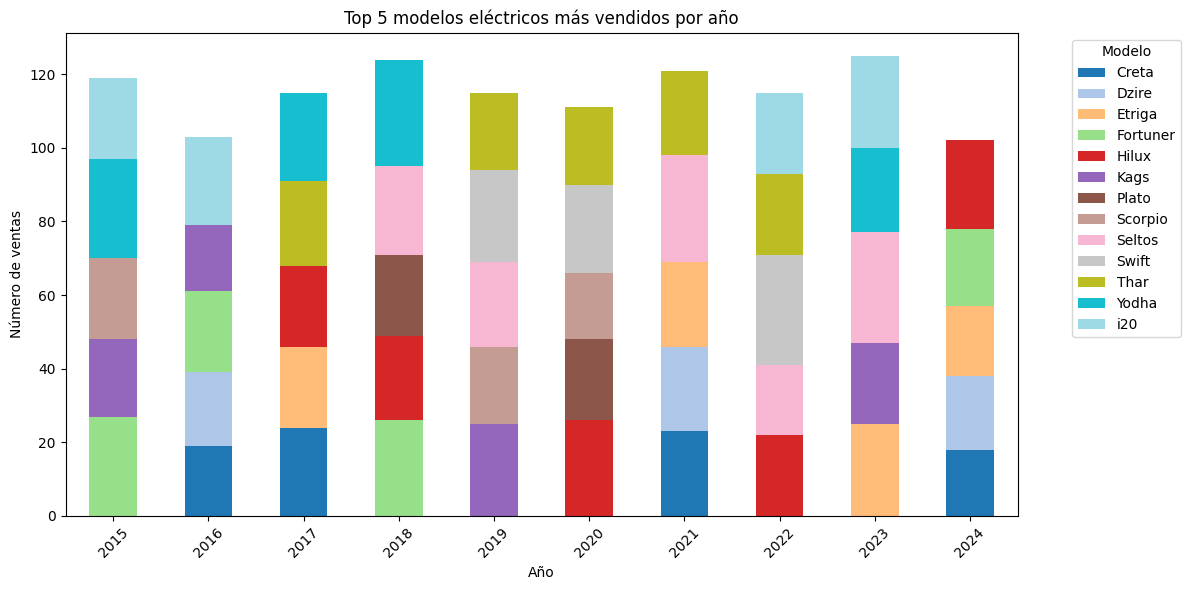

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("used_car_sales.csv")
df['Purchased Date'] = pd.to_datetime(df['Purchased Date'], errors='coerce')
df = df[df['Energy'] == 'Electric'].copy()

# Crear columna de año
df['Año'] = df['Purchased Date'].dt.year
df = df[df['Año'].between(2015, 2024)]

# Top 5 modelos más vendidos por año
top5_por_año = df.groupby(['Año', 'Car Name']).size().reset_index(name='Ventas')
top5_filtrado = top5_por_año.sort_values(['Año', 'Ventas'], ascending=[True, False])\
    .groupby('Año').head(5)

# Unir con los datos originales para conservar el conteo exacto
df_filtrado = df.merge(top5_filtrado[['Año', 'Car Name']], on=['Año', 'Car Name'])

# Agrupar para gráfica
ventas_modelos = df_filtrado.groupby(['Año', 'Car Name']).size().unstack().fillna(0)

# Graficar
ventas_modelos.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Top 5 modelos eléctricos más vendidos por año")
plt.ylabel("Número de ventas")
plt.xlabel("Año")
plt.xticks(rotation=45)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


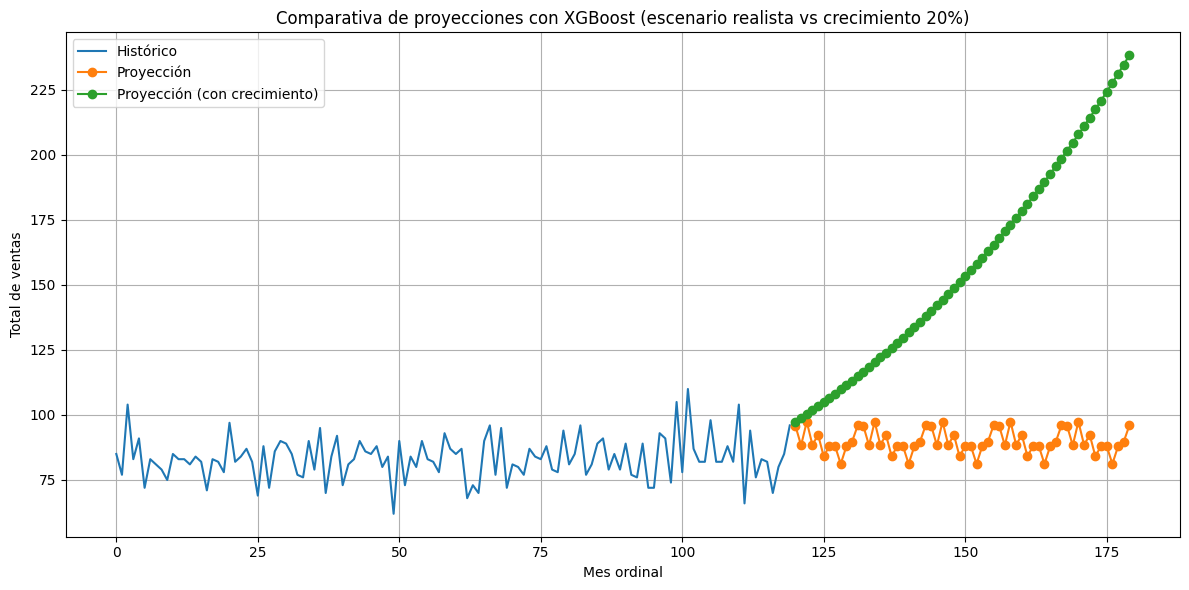

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datos
df = pd.read_csv("ventas_mensuales.csv")

df['Year-Month'] = pd.to_datetime(df['Year-Month'])
df = df.sort_values('Year-Month')
df['Mes_ordinal'] = np.arange(len(df))
df['Mes'] = df['Year-Month'].dt.month
df['Año'] = df['Year-Month'].dt.year
df['Mes_seno'] = np.sin(2 * np.pi * df['Mes'] / 12)
df['Mes_coseno'] = np.cos(2 * np.pi * df['Mes'] / 12)

# Entrenar modelo con variables enriquecidas
features = ['Mes_ordinal', 'Mes', 'Año', 'Mes_seno', 'Mes_coseno']
X = df[features]
y = df['Total_Ventas']
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X, y)

# Predicción histórica
y_pred = xgb.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

# Crear fechas futuras
future_months = 60
last_date = df['Year-Month'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=future_months, freq='MS')

df_future = pd.DataFrame()
df_future['Year-Month'] = future_dates
df_future['Mes_ordinal'] = np.arange(df['Mes_ordinal'].max() + 1, df['Mes_ordinal'].max() + 1 + future_months)
df_future['Mes'] = df_future['Year-Month'].dt.month
df_future['Año'] = df_future['Year-Month'].dt.year
df_future['Mes_seno'] = np.sin(2 * np.pi * df_future['Mes'] / 12)
df_future['Mes_coseno'] = np.cos(2 * np.pi * df_future['Mes'] / 12)

# Predicción futura base
X_future = df_future[features]
df_future['Total_Ventas'] = xgb.predict(X_future)
df_future['Tipo'] = 'Proyección'

# Crear variante con crecimiento del 20% anual
df_future_growth = df_future.copy()
monthly_growth_factor = (1 + 0.20) ** (1 / 12)
for i in range(len(df_future_growth)):
    if i == 0:
        df_future_growth.loc[i, 'Total_Ventas'] *= monthly_growth_factor
    else:
        df_future_growth.loc[i, 'Total_Ventas'] = df_future_growth.loc[i-1, 'Total_Ventas'] * monthly_growth_factor
df_future_growth['Tipo'] = 'Proyección (con crecimiento)'

# Datos históricos
df_real = df[['Mes_ordinal', 'Total_Ventas']].copy()
df_real['Tipo'] = 'Histórico'

# Combinar todo
df_crecimiento = pd.concat([
    df_real[['Mes_ordinal', 'Total_Ventas', 'Tipo']],
    df_future[['Mes_ordinal', 'Total_Ventas', 'Tipo']],
    df_future_growth[['Mes_ordinal', 'Total_Ventas', 'Tipo']]
], ignore_index=True)

# Graficar
plt.figure(figsize=(12, 6))
for tipo in df_crecimiento['Tipo'].unique():
    subset = df_crecimiento[df_crecimiento['Tipo'] == tipo]
    plt.plot(subset['Mes_ordinal'], subset['Total_Ventas'], label=tipo, marker='o' if 'Proyección' in tipo else '')

plt.title("Comparativa de proyecciones con XGBoost (escenario realista vs crecimiento 20%)")
plt.xlabel("Mes ordinal")
plt.ylabel("Total de ventas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



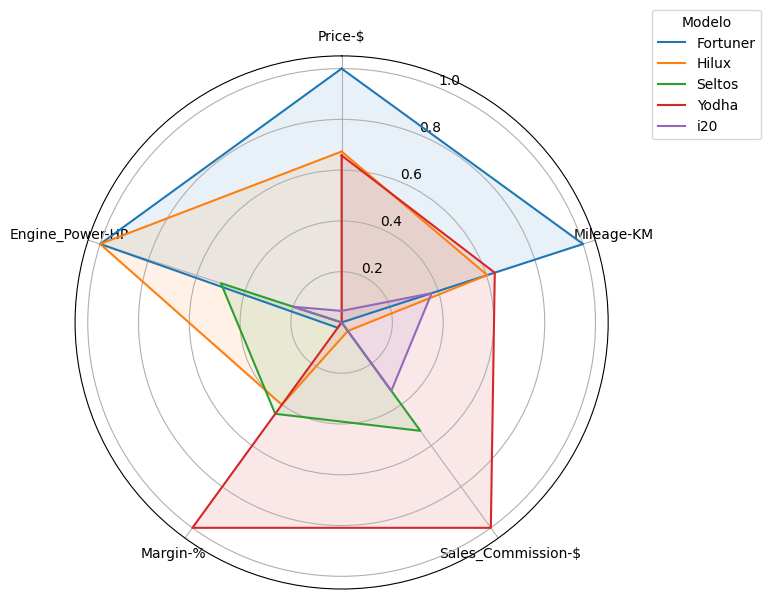

In [ ]:
# Filtrar solo coches eléctricos del dataset
df_electric = df[df['Energy'] == 'Electric']

# Obtener los 5 modelos eléctricos más vendidos
top_electric_models = df_electric['Car_Name'].value_counts().head(5).index.tolist()
df_top_electric = df_electric[df_electric['Car_Name'].isin(top_electric_models)]

# Calcular medias por modelo para variables cuantitativas
cols_quant = ['Price-$', 'Mileage-KM', 'Sales_Commission-$', 'Margin-%', 'Engine_Power-HP']
perfil_electric = df_top_electric.groupby('Car_Name')[cols_quant].mean()

# Normalizar valores entre 0 y 1
perfil_electric_norm = (perfil_electric - perfil_electric.min()) / (perfil_electric.max() - perfil_electric.min())

# Preparar radar chart
categorias = perfil_electric_norm.columns.tolist()
labels = perfil_electric_norm.index.tolist()
num_vars = len(categorias)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Crear gráfico radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for label in labels:
    values = perfil_electric_norm.loc[label].tolist() + [perfil_electric_norm.loc[label].tolist()[0]]
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categorias)
plt.legend(title="Modelo", loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


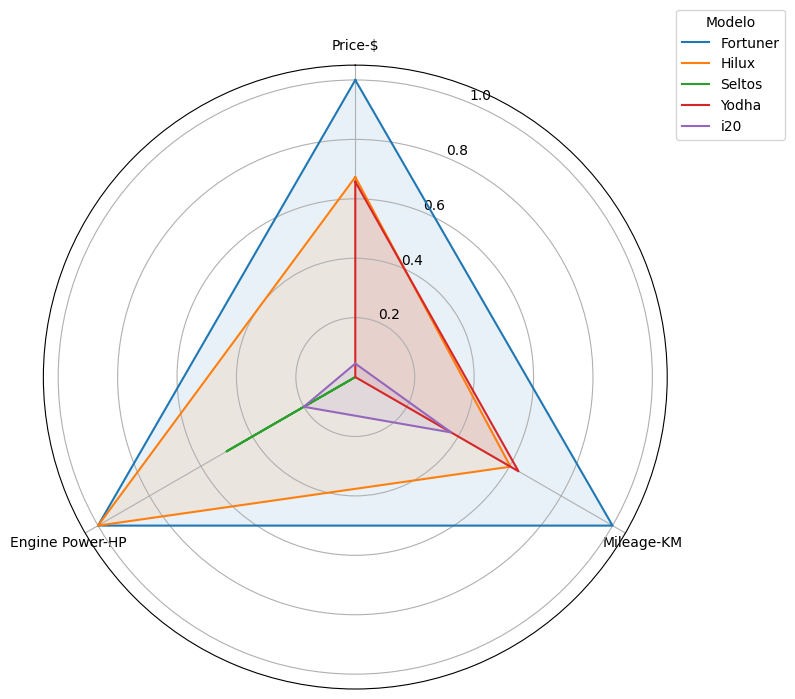

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("used_car_sales.csv")

# Convertir columnas numéricas
df['Price-$'] = pd.to_numeric(df['Price-$'], errors='coerce')
df['Mileage-KM'] = pd.to_numeric(df['Mileage-KM'], errors='coerce')
df['Engine Power-HP'] = pd.to_numeric(df['Engine Power-HP'], errors='coerce')

# Filtrar coches eléctricos
df_electric = df[df['Energy'] == 'Electric']

# Top 5 modelos eléctricos más vendidos
top_models = df_electric['Car Name'].value_counts().head(5).index.tolist()
df_top = df_electric[df_electric['Car Name'].isin(top_models)]

# Calcular medias de variables cuantitativas
cols = ['Price-$', 'Mileage-KM', 'Engine Power-HP']
perfil = df_top.groupby('Car Name')[cols].mean()

# Normalizar de 0 a 1
perfil_norm = (perfil - perfil.min()) / (perfil.max() - perfil.min())

# Preparar radar chart
categorias = perfil_norm.columns.tolist()
labels = perfil_norm.index.tolist()
num_vars = len(categorias)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for label in labels:
    valores = perfil_norm.loc[label].tolist() + [perfil_norm.loc[label].tolist()[0]]
    ax.plot(angles, valores, label=label)
    ax.fill(angles, valores, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categorias)
plt.legend(title="Modelo", loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title("")
plt.tight_layout()
plt.show()


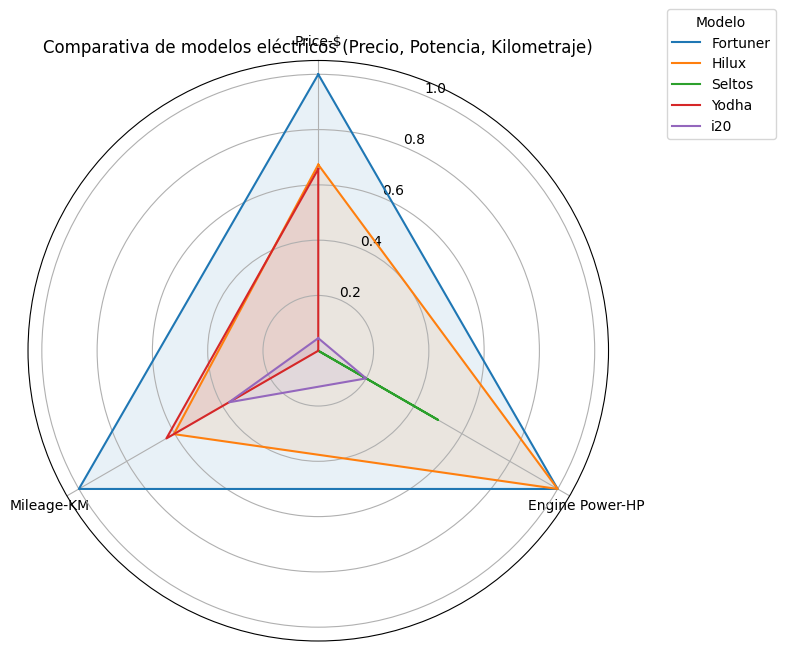

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar el dataset
df = pd.read_csv("used_car_sales.csv")

# Asegurar tipo correcto
df['Price-$'] = pd.to_numeric(df['Price-$'], errors='coerce')
df['Mileage-KM'] = pd.to_numeric(df['Mileage-KM'], errors='coerce')
df['Engine Power-HP'] = pd.to_numeric(df['Engine Power-HP'], errors='coerce')
df['Number of Seats'] = pd.to_numeric(df['Number of Seats'], errors='coerce')
df['Manufactured Year'] = pd.to_numeric(df['Manufactured Year'], errors='coerce')
df['Number of Doors'] = pd.to_numeric(df['Number of Doors'], errors='coerce')

# Filtrar coches eléctricos
df_electric = df[df['Energy'] == 'Electric']

# Top 5 modelos eléctricos más vendidos
top_models = df_electric['Car Name'].value_counts().head(5).index.tolist()
df_top = df_electric[df_electric['Car Name'].isin(top_models)]

# Escoger 3 variables importantes
cols = ['Price-$', 'Engine Power-HP', 'Mileage-KM']
perfil = df_top.groupby('Car Name')[cols].mean()

# Normalizar
perfil_norm = (perfil - perfil.min()) / (perfil.max() - perfil.min())

# Radar chart
categorias = perfil_norm.columns.tolist()
labels = perfil_norm.index.tolist()
num_vars = len(categorias)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for label in labels:
    values = perfil_norm.loc[label].tolist() + [perfil_norm.loc[label].tolist()[0]]
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categorias)
plt.legend(title="Modelo", loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title("Comparativa de modelos eléctricos (Precio, Potencia, Kilometraje)")
plt.tight_layout()
plt.show()


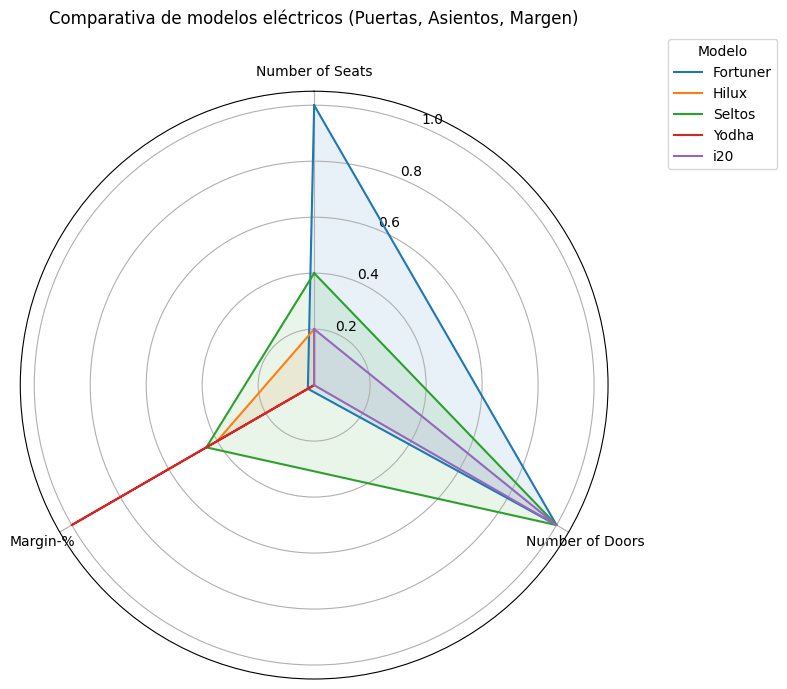

In [ ]:
# Reimportar librerías tras reinicio de entorno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("used_car_sales.csv")

# Asegurar tipo correcto en columnas relevantes
cols = ['Price-$', 'Mileage-KM', 'Engine Power-HP', 'Margin-%', 'Number of Seats', 'Number of Doors']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filtrar solo coches eléctricos
df_electric = df[df['Energy'] == 'Electric']

# Obtener los 5 modelos eléctricos más vendidos
top_models = df_electric['Car Name'].value_counts().head(5).index.tolist()
df_top = df_electric[df_electric['Car Name'].isin(top_models)]

# Seleccionar 3 variables distintas para este radar
cols_radar = ['Number of Seats', 'Number of Doors', 'Margin-%']

# Calcular medias por modelo
perfil = df_top.groupby('Car Name')[cols_radar].mean()

# Normalizar entre 0 y 1
perfil_norm = (perfil - perfil.min()) / (perfil.max() - perfil.min())

# Preparar gráfico radar
categorias = perfil_norm.columns.tolist()
labels = perfil_norm.index.tolist()
num_vars = len(categorias)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Crear gráfico radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for label in labels:
    values = perfil_norm.loc[label].tolist() + [perfil_norm.loc[label].tolist()[0]]
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categorias)
plt.legend(title="Modelo", loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title("Comparativa de modelos eléctricos (Puertas, Asientos, Margen)", y=1.1)
plt.tight_layout()
plt.show()


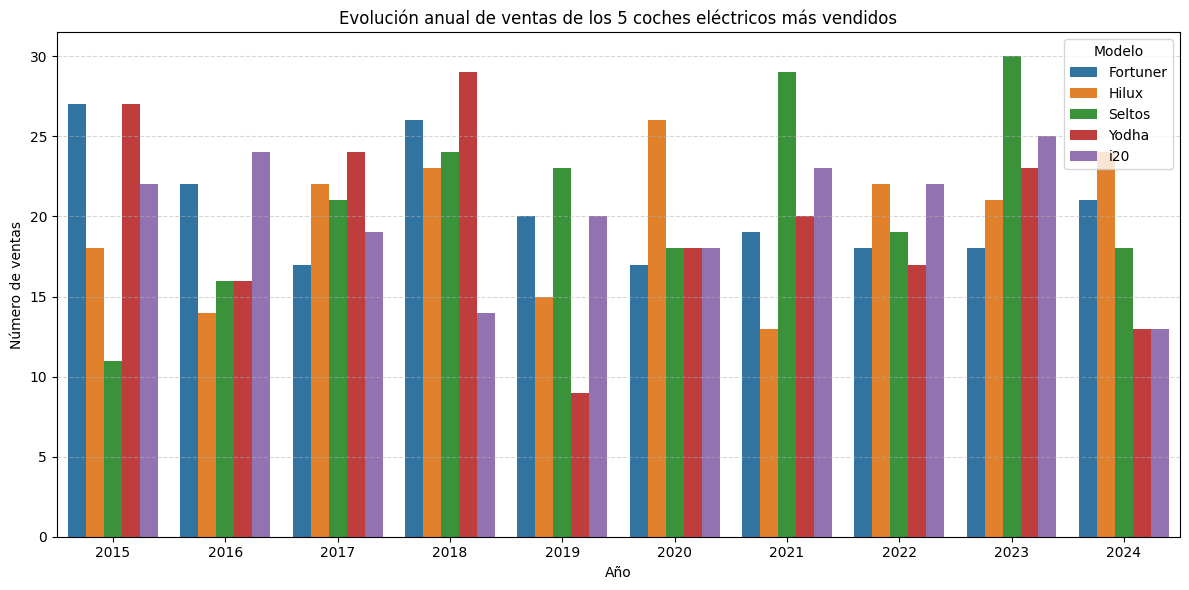

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("used_car_sales.csv")

# Asegurar formato de fecha
df['Purchased Date'] = pd.to_datetime(df['Purchased Date'], errors='coerce')
df['Año'] = df['Purchased Date'].dt.year

# Filtrar solo coches eléctricos
df_electric = df[df['Energy'] == 'Electric']

# Agrupar por modelo y año, contar ventas
ventas_modelo_anual = df_electric.groupby(['Car Name', 'Año']).size().reset_index(name='Ventas')

# Tomar los 5 modelos eléctricos más vendidos
top_modelos = df_electric['Car Name'].value_counts().head(5).index.tolist()
ventas_top_modelos = ventas_modelo_anual[ventas_modelo_anual['Car Name'].isin(top_modelos)]

# Crear gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=ventas_top_modelos, x='Año', y='Ventas', hue='Car Name')
plt.title("Evolución anual de ventas de los 5 coches eléctricos más vendidos")
plt.xlabel("Año")
plt.ylabel("Número de ventas")
plt.legend(title="Modelo")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


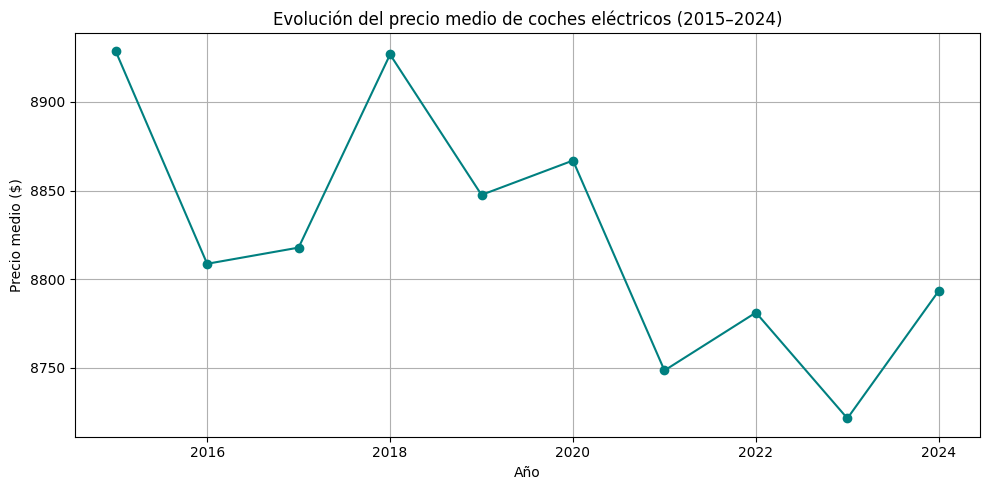

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("used_car_sales.csv")

# Filtrar solo coches eléctricos
df_electric = df[df['Energy'] == 'Electric'].copy()

# Asegurar tipo de fecha y extraer el año
df_electric['Purchased Date'] = pd.to_datetime(df_electric['Purchased Date'], errors='coerce')
df_electric['Año'] = df_electric['Purchased Date'].dt.year

# Asegurar tipo numérico en precio
df_electric['Price-$'] = pd.to_numeric(df_electric['Price-$'], errors='coerce')

# Agrupar por año y calcular precio medio
precio_medio_anual = df_electric.groupby('Año')['Price-$'].mean().dropna()

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(precio_medio_anual.index, precio_medio_anual.values, marker='o', color='teal')
plt.title("Evolución del precio medio de coches eléctricos (2015–2024)")
plt.xlabel("Año")
plt.ylabel("Precio medio ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calcular ventas proyectadas con crecimiento entre 2025 y 2030
ventas_2025_2030 = df_future_growth.copy()
ventas_2025_2030['Año'] = pd.to_datetime(ventas_2025_2030['Year-Month']).dt.year
ventas_totales_2025_2030 = ventas_2025_2030[ventas_2025_2030['Año'].between(2025, 2030)]['Total_Ventas'].sum()



In [ ]:
# Crear tabla resumen en DataFrame
tabla_doble = pd.DataFrame({
    'Escenario': ['Proyección base', 'Proyección con +20% anual'],
    'Ventas 2025–2030': [round(ventas_totales_2025_2030_base, 0), round(ventas_totales_2025_2030, 0)]
})

# Calcular incremento porcentual
crecimiento_pct = (ventas_totales_2025_2030 - ventas_totales_2025_2030_base) / ventas_totales_2025_2030_base * 100

# Mostrar resultados
tabla_doble['Diferencia vs base (%)'] = [0, f"{crecimiento_pct:.1f}%"]
tabla_doble


,Escenario,Ventas 2025–2030,Diferencia vs base (%)
0,Proyección base,5386.0,0
1,Proyección con +20% anual,9454.0,75.5%


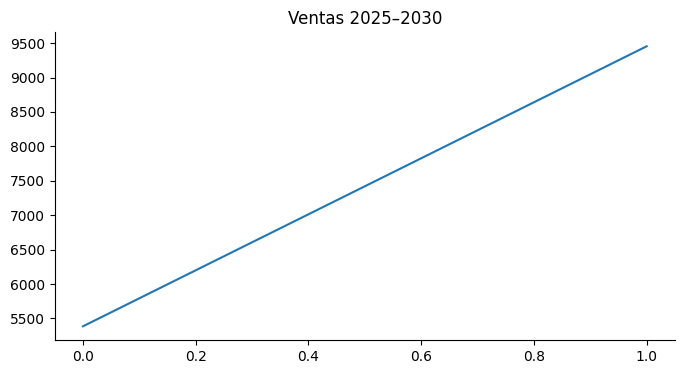

In [ ]:
# @title Ventas 2025–2030

from matplotlib import pyplot as plt
tabla_doble['Ventas 2025–2030'].plot(kind='line', figsize=(8, 4), title='Ventas 2025–2030')
plt.gca().spines[['top', 'right']].set_visible(False)

<ipython-input-6-cae9ef6638c4>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seats_count.index.astype(int), y=seats_count.values, palette='Greens_d')


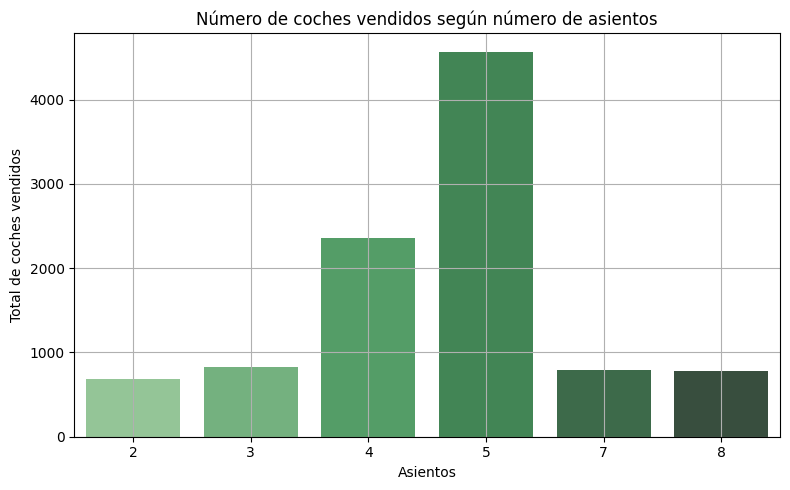

<ipython-input-6-cae9ef6638c4>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=doors_count.index.astype(int), y=doors_count.values, palette='Blues_d')


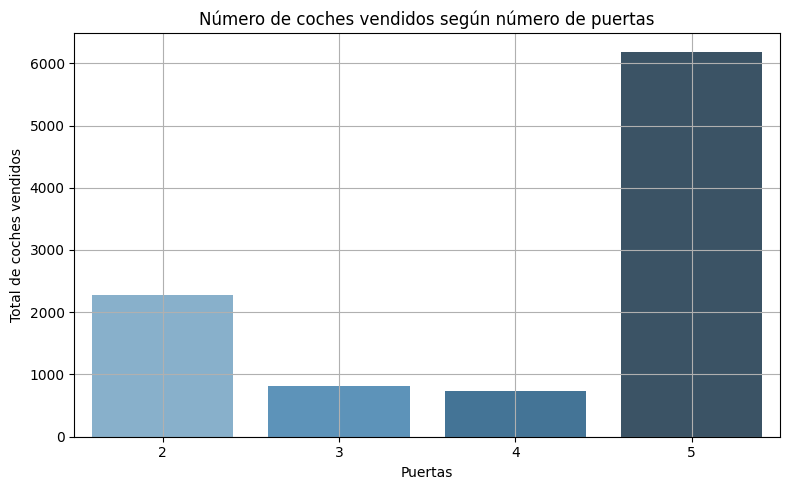

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Crear la carpeta si no existe
ruta_guardado = "C:/Users/Ilias/Desktop/TFG/Graficas"
os.makedirs(ruta_guardado, exist_ok=True)

# Cargar el dataset
df = pd.read_csv("used_car_sales.csv")
df['Purchased Date'] = pd.to_datetime(df['Purchased Date'], errors='coerce')
df = df[(df['Purchased Date'] >= '2015-01-01') & (df['Purchased Date'] <= '2024-12-31')]
df['Año'] = df['Purchased Date'].dt.year

# ===== GRÁFICO 1: Asientos =====
df['Number of Seats'] = pd.to_numeric(df['Number of Seats'], errors='coerce')
seats_count = df['Number of Seats'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=seats_count.index.astype(int), y=seats_count.values, palette='Greens_d')
plt.title("Número de coches vendidos según número de asientos")
plt.xlabel("Asientos")
plt.ylabel("Total de coches vendidos")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{ruta_guardado}/grafico_asientos.png")
plt.show()

# ===== GRÁFICO 2: Puertas =====
df['Number of Doors'] = pd.to_numeric(df['Number of Doors'], errors='coerce')
doors_count = df['Number of Doors'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=doors_count.index.astype(int), y=doors_count.values, palette='Blues_d')
plt.title("Número de coches vendidos según número de puertas")
plt.xlabel("Puertas")
plt.ylabel("Total de coches vendidos")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{ruta_guardado}/grafico_puertas.png")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer el archivo original
df = pd.read_csv("used_car_sales.csv", sep=",", quotechar='"', encoding='utf-8', engine="python", on_bad_lines='skip')

# Limpiar columnas
df.columns = df.columns.str.strip().str.replace(" ", "_")
df['Purchased_Date'] = pd.to_datetime(df['Purchased_Date'], errors='coerce')
df = df[(df['Purchased_Date'] >= '2015-01-01') & (df['Purchased_Date'] <= '2024-12-31')]
df['Año'] = df['Purchased_Date'].dt.year


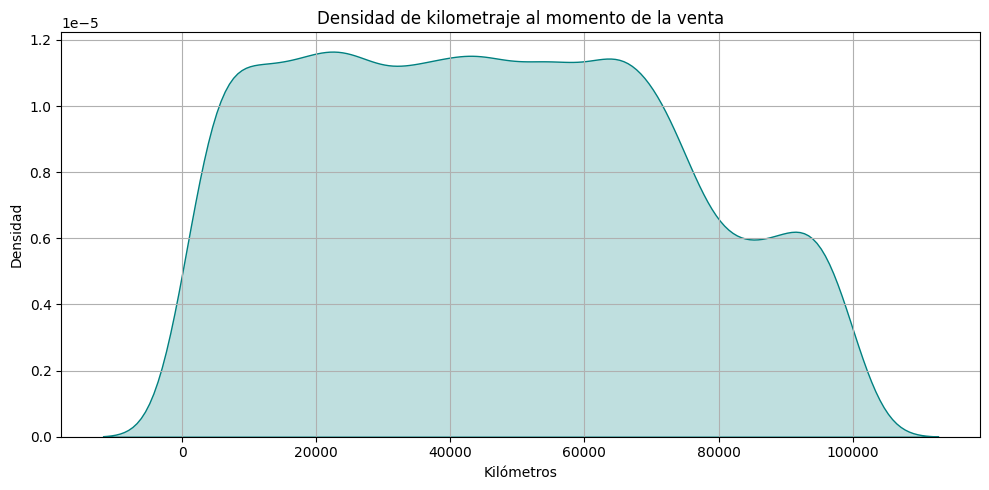

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df_km['Mileage-KM'], fill=True, color='teal')
plt.title("Densidad de kilometraje al momento de la venta")
plt.xlabel("Kilómetros")
plt.ylabel("Densidad")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-15-b14bbb589f40>:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


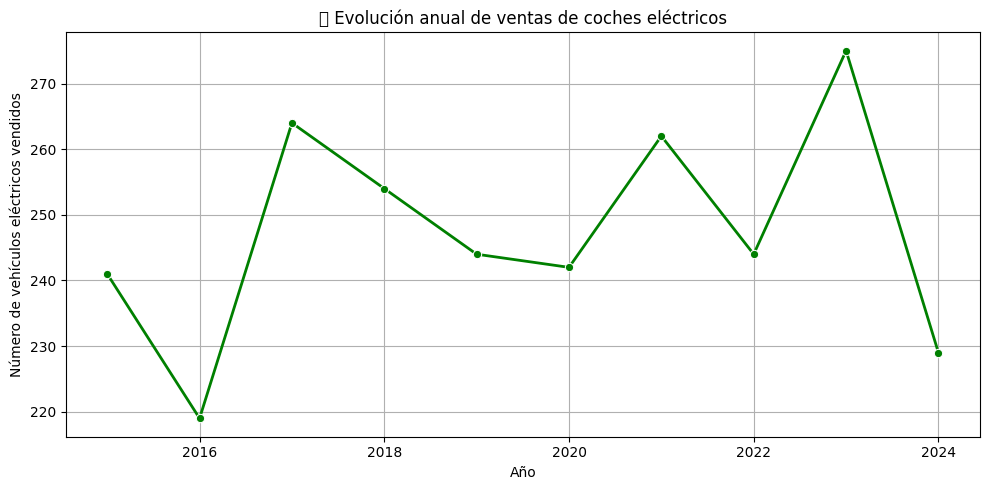

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener esta parte si no la hiciste antes
df['Purchased_Date'] = pd.to_datetime(df['Purchased_Date'], errors='coerce')
df['Año'] = df['Purchased_Date'].dt.year

# Filtrar solo coches eléctricos
df_electric = df[df['Energy'] == 'Electric']

# Contar ventas por año
ventas_electricos = df_electric.groupby('Año').size()

# Gráfico
plt.figure(figsize=(10, 5))
sns.lineplot(x=ventas_electricos.index, y=ventas_electricos.values, marker='o', linewidth=2, color='green')
plt.title(" Evolución anual de ventas de coches eléctricos")
plt.xlabel("Año")
plt.ylabel("Número de vehículos eléctricos vendidos")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Cargar datos
df = pd.read_csv("ventas_mensuales.csv")
df['Year-Month'] = pd.to_datetime(df['Year-Month'])
df = df.sort_values('Year-Month')

# Variables temporales
df['Mes'] = df['Year-Month'].dt.month
df['Año'] = df['Year-Month'].dt.year
df['Mes_seno'] = np.sin(2 * np.pi * df['Mes'] / 12)
df['Mes_coseno'] = np.cos(2 * np.pi * df['Mes'] / 12)

# Escalar datos
scaler = MinMaxScaler()
features = ['Total_Ventas', 'Mes_seno', 'Mes_coseno']
scaled_data = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['Year-Month'] = df['Year-Month']

# Crear secuencias multivariables
def crear_secuencias_multivariable(df_scaled, n_steps):
    X, y = [], []
    for i in range(n_steps, len(df_scaled)):
        X.append(df_scaled.iloc[i-n_steps:i][['Mes_seno', 'Mes_coseno', 'Total_Ventas']].values)
        y.append(df_scaled.iloc[i]['Total_Ventas'])
    return np.array(X), np.array(y)

X, y = crear_secuencias_multivariable(scaled_df, 12)

# Dividir en train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (86, 12, 3)
X_test: (22, 12, 3)
y_train: (86,)
y_test: (22,)


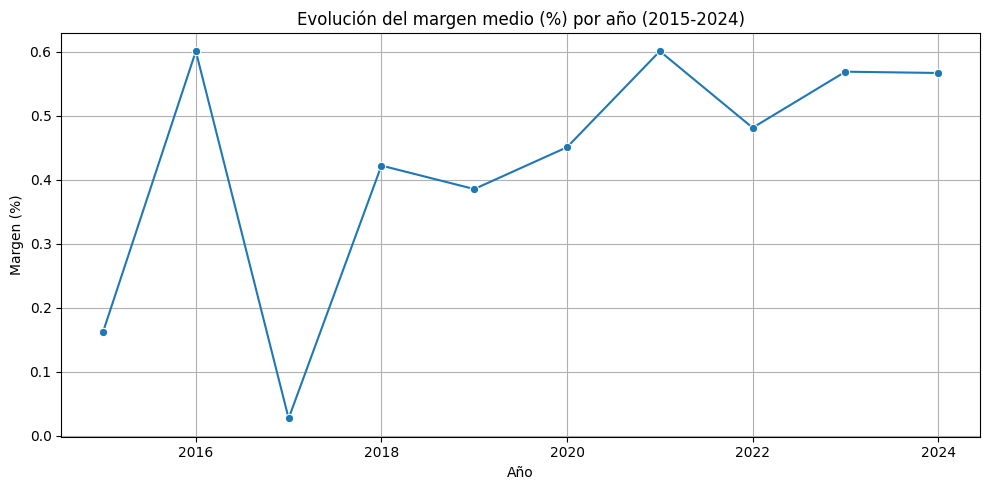

In [ ]:
# Reimportar librerías tras el reinicio del entorno
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("used_car_sales.csv")

# Asegurar que la columna de fecha es datetime y extraer año
df['Purchased Date'] = pd.to_datetime(df['Purchased Date'], errors='coerce')
df['Año'] = df['Purchased Date'].dt.year

# Convertir margen a numérico
df['Margin-%'] = pd.to_numeric(df['Margin-%'], errors='coerce')

# Filtrar entre 2015 y 2024
df_filtrado = df[(df['Año'] >= 2015) & (df['Año'] <= 2024)]

# Calcular el margen medio por año
margen_anual = df_filtrado.groupby('Año')['Margin-%'].mean().reset_index()

# Graficar
plt.figure(figsize=(10, 5))
sns.lineplot(data=margen_anual, x='Año', y='Margin-%', marker='o')
plt.title('Evolución del margen medio (%) por año (2015-2024)')
plt.ylabel('Margen (%)')
plt.xlabel('Año')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(100, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='tanh'),
    Dense(50, activation='relu'),
    Dense(1)
])


model.compile(optimizer='adam', loss='mae')
history = model.fit(X_train, y_train, epochs=100, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


<ipython-input-18-f37e898c9717>:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


RMSE: 11.64
R²: -0.11


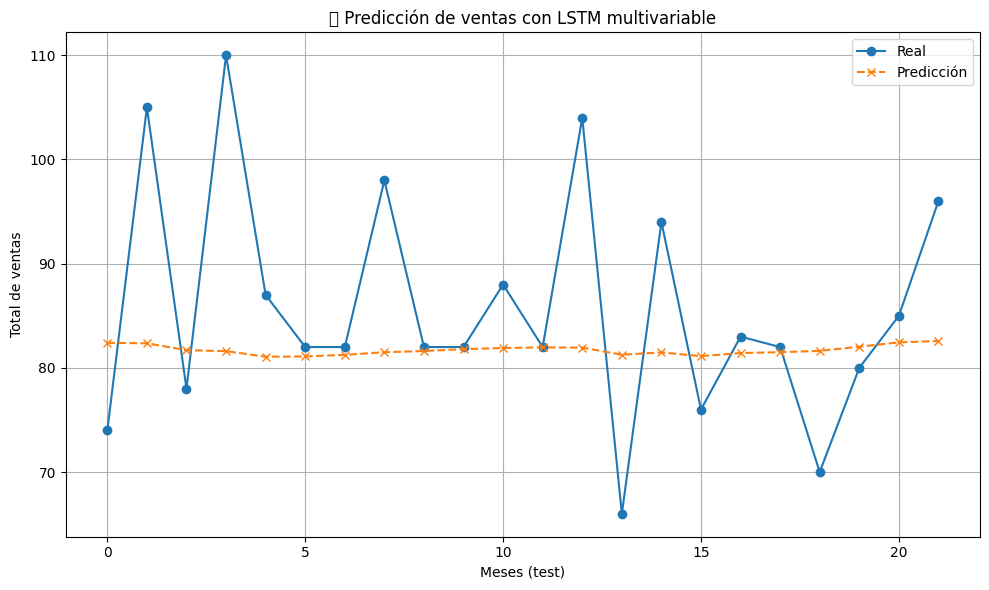

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predicciones
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate([y_pred_scaled, np.zeros((len(y_pred_scaled), 2))], axis=1))[:,0]
y_test_real = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 2))], axis=1))[:,0]

# Métricas
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test_real, label='Real', marker='o')
plt.plot(y_pred, label='Predicción', linestyle='--', marker='x')
plt.title('📈 Predicción de ventas con LSTM multivariable')
plt.xlabel('Meses (test)')
plt.ylabel('Total de ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# PASO 2: Preprocesamiento con nuevas variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("ventas_mensuales.csv")
df['Year-Month'] = pd.to_datetime(df['Year-Month'])
df = df.sort_values('Year-Month')

# Variables temporales y derivadas
df['Mes'] = df['Year-Month'].dt.month
df['Mes_seno'] = np.sin(2 * np.pi * df['Mes'] / 12)
df['Mes_coseno'] = np.cos(2 * np.pi * df['Mes'] / 12)
df['lag_1'] = df['Total_Ventas'].shift(1)
df['rolling_3'] = df['Total_Ventas'].rolling(3).mean()
df['diff_pct'] = df['Total_Ventas'].pct_change()

# Eliminar filas con NaN creadas por shift y rolling
df = df.dropna().reset_index(drop=True)

# Escalado
features = ['Total_Ventas', 'Mes_seno', 'Mes_coseno', 'lag_1', 'rolling_3', 'diff_pct']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)


In [ ]:
# PASO 3: Crear secuencias para LSTM
def crear_secuencias(df_scaled, n_steps=12):
    X, y = [], []
    for i in range(n_steps, len(df_scaled)):
        X.append(df_scaled.iloc[i-n_steps:i].values)
        y.append(df_scaled.iloc[i]['Total_Ventas'])
    return np.array(X), np.array(y)

X, y = crear_secuencias(scaled_df, 12)

# División train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
# PASO 4: Definición y entrenamiento del modelo LSTM mejorado
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(128, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=8, callbacks=[early_stop], verbose=0)
# PASO 5: Evaluación del modelo
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack([y_pred_scaled, np.zeros((len(y_pred_scaled), len(features)-1))]))[:, 0]
y_test_real = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features)-1))]))[:, 0]

rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.2f}")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
✅ RMSE: 12.97
✅ R²: -0.38
